In [1]:
#Import matplotlib and PyTorch

import matplotlib.pyplot as plt
import numpy as np

import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

mps_device = torch.device("mps")

In a 4D pytorch tensor, the 4 dimensions (labelled 0 to 3) are:

0. Batch size
1. Number of channels, e.g. 1 for grayscale, 3 for RGB 
2. Height of each image in pixels.
3. Width of each image in pixels.

We need certain rotations and flips to be available to us, so we define functions:

rotate_180(x): to be used to add invariance with respect to 180 degree rotation. 
Reverses the 3rd and 4th dimensions ([2,3]). 
x_flip(x): flips left-right. Flips the 4th dimension. 
y_flip(x): flips top-bottom. Flips the 3rd dimension. 

x is our tensor.

In [9]:
def rotate_180(x):
    return torch.flip(x,[2,3])

def x_flip(x):
    return torch.flip(x,[3])

def y_flip(x):
    return torch.flip(x,[2])

As we are looking to form 2 groups of test/train datasets (non-modified chiral and 
50% flipped achiral), we need to do some preprocessing of our data into these sets.

These 2 groups will be named as follows (taking inspiration on from Dr Lester's 
previous work):

1. S
2. SLR

where 'S' is for snail, and 'LR' (Left-Right) labels the achiral group.

We define the Group class, which will allow us reference different aspects of 
the objects we are dealing with, and to view our results in the future. 

In [10]:
class Group:
    def __init__(self,name, train=True, trainloader=None, testloader=None, net=None):
        self.name=name
        self.train=train
        if trainloader is not None:
            self.set_trainloader(trainloader)
        if testloader is not None:
            self.set_testloader(testloader)
        if net is not None:
            self.set_net(net)

    def return_test_images(self):
        dataiter1 = iter(self.testloader)
        images, labels = next(dataiter1)
        images, labels = images.to(mps_device), labels.to(mps_device)
        return images

    def return_train_images(self):
        dataiter2 = iter(self.trainloader)
        images, labels = next(dataiter2)
        images, labels = images.to(mps_device), labels.to(mps_device)
        return images

    def set_trainloader(self, loader):
        self.trainloader = loader

    def set_testloader(self, loader):
        self.testloader = loader

    def set_net(self, net):
        self.net = net
        import torch.optim as optim
        self.optimizer = optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9)

    def parity_calculations(self, net_outputs, test, output):
        from math import sqrt
        num_positives=torch.count_nonzero(torch.gt(net_outputs,0).int()).item()
        num_negatives=torch.count_nonzero(torch.lt(net_outputs,0).int()).item()
        num_zeros=torch.count_nonzero(torch.eq(net_outputs,0).int()).item()
        num_total=num_positives+num_zeros+num_negatives
        poisson_p=num_positives/num_total
        poisson_q=1.0-poisson_p
        poisson_mean = num_total*poisson_p
        poisson_variance = num_total*poisson_p*poisson_q
        poisson_sd=sqrt(poisson_variance)

        fractional_mean = poisson_mean/num_total
        fractional_sd = poisson_sd/num_total

        if output == True:  
            print("On",("test" if test else "train"),": Positive Fraction ",100*fractional_mean,"+-",100*fractional_sd,"%")
        elif output == False:
            print(100*fractional_mean,100*fractional_sd)


    def output_values(self, output, test):
        if test == True:
            self.parity_calculations(self.net(self.return_test_images()), test, output)
        elif test == False:
            self.parity_calculations(self.net(self.return_train_images()), test, output)



Create the test and train datasets:

Now, to generate a tensor from the image input. We will take the image input and 
put it through 4 transforms sequentially using transforms.Compose()

transforms.ToTensor(): converts the image into 3 RGB colour channels (or 1 
greyscale channel)
transforms.Normalise(mean, std): normalises the tensor according to mean and s.d. parameters
transforms.Resize(x): resizes the image such that the shortest side is now x pixels
Transforms.CentreCrop(x): crops the image in a square at the centre with side length x

In [14]:
#0.5s

#normal:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225]), transforms.Resize(64, antialias=True), transforms.CenterCrop(64)])

#for greyscale
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5],  std=[0.5, 0.5, 0.5]), transforms.Resize(64, antialias=True), transforms.CenterCrop(64)])


folder_name = "model"

test_path = "/Users/jamesgibbon/Library/CloudStorage/OneDrive-UniversityofCambridge/Natural Sciences/Part III/Project/" + folder_name + "/test"
train_path = "/Users/jamesgibbon/Library/CloudStorage/OneDrive-UniversityofCambridge/Natural Sciences/Part III/Project/" + folder_name + "/train"

testset = ImageFolder(root=test_path, transform=transform)
print(f"Number of test images: {len(testset)}")

trainset = ImageFolder(root=train_path, transform=transform)
print(f"Number of training images: {len(trainset)}")


Number of test images: 400
Number of training images: 1600


In [15]:
#4 mins for 125,000 images (17s per 10000)

def flip_dataset(dataset):
    flip_transform = transforms.RandomHorizontalFlip(p=1.0)
    flipped_dataset = []
    count = 0

    for image, label in dataset:
        if np.random.binomial(1, 0.5):
            image = flip_transform(image)
        
        flipped_dataset.append((image, label))
        count +=1
        if count%1000 == 0:
            print(count, "Done!")


    
    return flipped_dataset

testset_SLR = flip_dataset(testset)
trainset_SLR = flip_dataset(trainset)

1000 Done!


In [16]:
batch_size=64
factor = len(testset)/2447
#factor = 1


print("Factor is ", factor)

trainloader_S = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)  
testloader_S = torch.utils.data.DataLoader(testset, batch_size=int(len(testset)/factor), shuffle=True, pin_memory=True, num_workers=4)

trainloader_SLR = torch.utils.data.DataLoader(trainset_SLR, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
testloader_SLR = torch.utils.data.DataLoader(testset_SLR, batch_size=int(len(testset)/factor), shuffle=True, pin_memory=True, num_workers=4)

print(trainloader_S.batch_size,testloader_S.batch_size)

Factor is  0.1634654679199019
64 2447


In [17]:
groups = {
    "S" : Group("S", train=False, trainloader=trainloader_S, testloader=testloader_S),
    "SLR" : Group("SLR", train=False, trainloader=trainloader_SLR, testloader=testloader_SLR),
    }

In [18]:
#CHECK TRAINLOADER LENGTH

for name, group in groups.items():
    num_batches = len(group.trainloader)
    batch_size = group.trainloader.batch_size
    num_images = num_batches * batch_size
    print(f"Number of images in {name}: {num_images}")

Number of images in S: 1600
Number of images in SLR: 1600


S (train)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


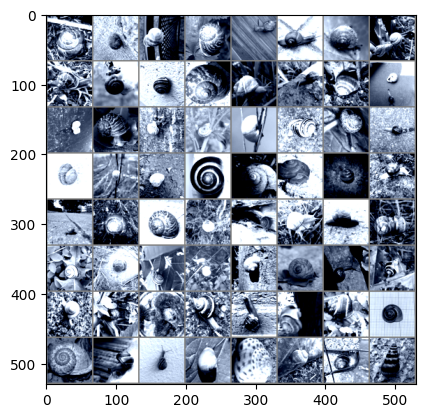

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SLR (train)


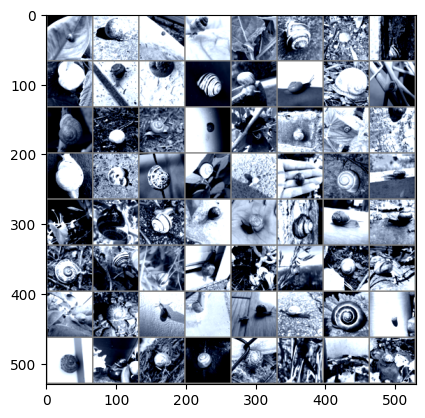

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#PLOT IMAGES - 25s
for name, group in groups.items():
    dataiter = iter(group.trainloader)
    print(name, "(train)")
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.tensor_size=torch.tensor([64,64]) #IMAGE SIZE

        self.kernel_1_size = (5,5)
        self.kernel_2_size = (5,5)
        
        self.conv1 = nn.Conv2d(3, 16, self.kernel_1_size,1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, self.kernel_1_size,1)
        self.fc1 = nn.Linear(32 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        answer = self.forward_worker(x)
        answer = answer + self.forward_worker(rotate_180(x))
        answer = answer - self.forward_worker(y_flip(x))
        answer = answer - self.forward_worker(x_flip(x))
        return answer/4.0

    def forward_worker(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        #Flatten x along "channel" dimension - we will create a 2D tensor with dimensions
        #(batch size, number of channels * height * width)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sum(x, dim=1)
        return x

model = Net().to(mps_device)
print(model)

for group in groups.values():
    group.set_net(model)



Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5408, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)


Define a function that outputs positive fraction values for a group

In [12]:
def positive_fraction(groupname, message, attempts=1, output = True, test = True):
    group = groups[groupname]
    for _ in range(attempts):
        print(message,group.name)
        group.output_values(output,test)
            
        print()

#before training - 14s
#positive_fraction("S","Before Training",1, output = True, test = True)

Training! We will do this group-wise, using: https://gist.github.com/llSourcell/a0c1185e1b426ae598bde2be8c321a95

In [13]:
def train_group(group, no_of_epochs):  

    print('Start Training',group.name)
    #Output current performance
    #group.output_values()
    print('\n')
    for epoch in range(no_of_epochs):
        #Set loss to 0
        running_loss = 0.0
        for i, data in enumerate(group.trainloader, 0):
            #Import data
            inputs, labels = data
            inputs, labels = inputs.to(mps_device), labels.to(mps_device)
            
            #Zero parameter gradients
            group.optimizer.zero_grad()

            #Calculate std and mean of the outputs of the net
            std = torch.std(group.net(inputs))
            mean = torch.mean(group.net(inputs))
              
            #we want to MAXIMISE mean/std, so we want to MINIMISE -mean/std
            loss = -mean/std

            #enforce the minimisation of the loss, and update the parameters 
            #based on the gradients computed in backpropagation (using SGD)
            loss.backward()
            group.optimizer.step()


            # print statistics
            running_loss += (-loss).item()
            print_freq=100
            if i % print_freq == print_freq-1:
                print('[Epoch %d, Batch %d] loss: %.3f' %(epoch + 1, i + 1, running_loss/print_freq ))
                running_loss = 0.0
                #group.output_values()
        
        # model_dir = '/Users/jamesgibbon/Library/CloudStorage/OneDrive-UniversityofCambridge/Natural Sciences/Part III/Project/Hands Removed Helicoid/'        
        # epoch_plus_1 = str(1 + epoch)
        # run_identifier = "_" + epoch_plus_1 + "E_BS16_NH_1"
        # PATH = model_dir+group.name+run_identifier+'.pth'
        # torch.save(group.net.state_dict(),PATH)
        #group.output_values(output = True, test = True)
        print("Epoch ", epoch+1, " Done!" )
        print('\n')
    print('Finished Training',group.name)    
    #group.output_values(output = False, test = True)
    print('\n')

In [14]:
def train_and_save(extension, no_of_epochs):

    for name, group in groups.items():  
        
        train_group(group, no_of_epochs)
        
        folder_name = "BLACKWHITEHRH"
        model_dir = "/Users/jamesgibbon/Library/CloudStorage/OneDrive-UniversityofCambridge/Natural Sciences/Part III/Project/" + folder_name + "/"
        PATH = model_dir+name+extension+'.pth'
        
        torch.save(group.net.state_dict(),PATH)
        
def load(groupname, extension):
    folder_name = "BLACKWHITEHRH"
    model_dir = "/Users/jamesgibbon/Library/CloudStorage/OneDrive-UniversityofCambridge/Natural Sciences/Part III/Project/" + folder_name + "/"
    
    group = groups[groupname]
    name = group.name
    NAME = name + extension + '.pth'
    group.net.load_state_dict(torch.load(model_dir+NAME))


In [15]:
print(torch.has_mps)
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True
True


In [16]:
#TRAIN - takes 2 minutes per dataset (S and SLR) per epoch, running through 100,000 images
train_and_save("_END15E_BS64_BLACKWHITEHRH", 15)

Start Training S


[Epoch 1, Batch 100] loss: 0.010
[Epoch 1, Batch 200] loss: 0.036
[Epoch 1, Batch 300] loss: 0.031
[Epoch 1, Batch 400] loss: 0.045
[Epoch 1, Batch 500] loss: 0.024
[Epoch 1, Batch 600] loss: 0.050
[Epoch 1, Batch 700] loss: 0.071
[Epoch 1, Batch 800] loss: 0.078
[Epoch 1, Batch 900] loss: 0.072
[Epoch 1, Batch 1000] loss: 0.087
[Epoch 1, Batch 1100] loss: 0.084
[Epoch 1, Batch 1200] loss: 0.103
[Epoch 1, Batch 1300] loss: 0.106
[Epoch 1, Batch 1400] loss: 0.108
[Epoch 1, Batch 1500] loss: 0.085
Epoch  1  Done!


[Epoch 2, Batch 100] loss: 0.115
[Epoch 2, Batch 200] loss: 0.124
[Epoch 2, Batch 300] loss: 0.149
[Epoch 2, Batch 400] loss: 0.105
[Epoch 2, Batch 500] loss: 0.127
[Epoch 2, Batch 600] loss: 0.128
[Epoch 2, Batch 700] loss: 0.142
[Epoch 2, Batch 800] loss: 0.131
[Epoch 2, Batch 900] loss: 0.122
[Epoch 2, Batch 1000] loss: 0.151
[Epoch 2, Batch 1100] loss: 0.164
[Epoch 2, Batch 1200] loss: 0.143
[Epoch 2, Batch 1300] loss: 0.180
[Epoch 2, Batch 1400] loss: 0

In [17]:
epoch_no = 15

for groupname in ["S","SLR"]:
    print("Batch Size is", testloader_S.batch_size)
    load(groupname,"_END"+str(epoch_no)+"E_BS64_BLACKWHITEHRH")
    positive_fraction(groupname, "After training for " + str(epoch_no) + " Epochs:", attempts = int(factor), output = False, test = True)


Batch Size is 2447
After training for 15 Epochs: S
69.26849203105844 0.9327018056675342

After training for 15 Epochs: S
68.94156109521865 0.9354345004590106

After training for 15 Epochs: S
69.71802206783818 0.9288544442259699

After training for 15 Epochs: S
69.10502656313854 0.9340749977156474

After training for 15 Epochs: S
69.8406211687781 0.9277869471952022

After training for 15 Epochs: S
69.59542296689824 0.9299141104747116

After training for 15 Epochs: S
69.8406211687781 0.9277869471952022

After training for 15 Epochs: S
72.3334695545566 0.9043364036003787

After training for 15 Epochs: S
70.8214139762975 0.9189617460225962

After training for 15 Epochs: S
70.94401307723743 0.9178225142380295

Batch Size is 2447
After training for 15 Epochs: SLR
51.36902329382917 1.010392620184427

After training for 15 Epochs: SLR
49.81610134859011 1.010764737226037

After training for 15 Epochs: SLR
51.36902329382917 1.010392620184427

After training for 15 Epochs: SLR
48.63097670617082 1

In [ ]:
for i in range(15):
    for groupname in ["S","SLR"]:
        load(groupname,"_"+str(1+i)+"E_BS16_NH_1")
        positive_fraction(groupname, "(TESTSET) After training for " + str(i+1) + " Epochs:", attempts = 1, output = False, test = True)